In [1]:
import cv2 as cv
import numpy as np
import onnxruntime as ort
import onnx
import os
import torch
import time
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

1. QnnGPU.dll - showing very minimal GPU usage
2. All other DLL - only show CPU usage
3. No DLL downloaded with SDK for NPU (HEXAGON) 

In [ ]:
# ONNX Session Setup
model_subdirectory = "hrnet_pose"
model_name = "hrnet_pose.onnx"
## What is AARCH64
system = "aarch64-windows-msvc"#"arm64x-windows-msvc"# x86_64-windows-msvc #aarch64-windows-msvc
model_path = os.path.join("models",model_subdirectory,model_name)
qnn_dll_path = os.path.join("C:\\","Users","DFS","Desktop","qnn_sdk","qairt","2.26.0.240828","lib",system,"QnnHtp.dll") #QnnGpu #SNPE.dll #QnnHtp #Genie #QnnCpu
profile_path = os.path.join("models",model_subdirectory,model_name.replace(".onnx","profile"))

options = ort.SessionOptions()
session = ort.InferenceSession(model_path,
                                sess_options= options,
                                providers= ["QNNExecutionProvider"], # CPUExecutionProvider
                                provider_options= [{"backend_path": qnn_dll_path,
                                                    "profiling_level":"detailed",
                                                    "profiling_file_path":profile_path}])
# Retrieve expected input from model
inputs = session.get_inputs()
input_0 = inputs[0] #Only need one example

In [ ]:
input_0.shape

In [ ]:
input_0.type

In [ ]:
input_0.name

### Input Frame needs to be transformed to the below parameters based on get_inputs()
1. Shape: (1,3,256,192) => (B,C,H,W)
2. Datatype: Float 32
3. Name: Image

In [ ]:
# PyTorch Frame Transform Setup
expected_shape = input_0.shape

transformer = v2.Compose([
    v2.Resize(size=(expected_shape[2],expected_shape[3]),interpolation=InterpolationMode.BICUBIC),
    v2.ToDtype(torch.float32, scale=False),  #v2.ToDtype(torch.float32, scale=False)
    v2.ToTensor()
])

#Optimization for better performance, no need to convert to PIL
def custom_transform(frame, expected_shape):
    frame = cv.resize(frame, (expected_shape[2],expected_shape[3]), interpolation=cv.INTER_CUBIC)
    frame = frame.astype(np.float32)
    return frame

In [ ]:
expected_shape

In [ ]:
cap = cv.VideoCapture(1)

if not cap.isOpened():
    print("Some shit just went bad")
    exit()

og_height, og_width = expected_shape[2], expected_shape[3]
output_height, output_width = 64, 48

scaler_height = og_height/output_height
scaler_width = og_width/output_width
    
while True:
    # time.sleep(1)
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting...")
        break

    # To apply rotation frame needs to be in PIL format
    
    frame = Image.fromarray(frame)#Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2HSV)) 
    frame = transformer(frame) #
    frame = frame.permute(1,2,0).numpy() #np.transpose(frame,(1,2,0)) #
    
    ## Will need to permute frame to shape (C, H, W) before inference
    # This is equivalent to frame.permute(2,0,1) then frame.unsqueeze(0) 
    # below uses numpy array since we convert above
    ########################################################################
    ## INFERENCE
    ########################################################################
    inference_frame = np.expand_dims(np.transpose(frame, (2,0,1)), axis=0) 
    outputs = session.run(None, {input_0.name:inference_frame})
    output_tensor = torch.tensor(outputs).squeeze(0).squeeze(0)
    keypoints_coordinates = []
    for i in range(output_tensor.shape[0]):
        # Each i corresponds to a different keypoint
        heatmap = output_tensor[i]
        # Grabs max value from heatmap and convert this to height, width
        max_val = torch.argmax(heatmap)
        img_height, img_width = torch.unravel_index(max_val, heatmap.shape) #coords = torch.unravel_index(max_val, heatmap.shape)
        coords = (int(img_height*scaler_height), int(img_width*scaler_width))
        keypoints_coordinates.append(coords)
    ########################################################################
    ########################################################################
    ########################################################################

    # MAP KEYPOINTS BACK TO ORIGINAL FRAME THEN DISPLAY THAT FRAME
    frame = (frame*255).astype(np.uint8)
    frame = frame.copy()
    for (y,x) in keypoints_coordinates:
        cv.circle(frame, (x,y), radius=3, color=(0,0,255), thickness=-1)
        
    frame = cv.resize(frame, (640,480), interpolation=cv.INTER_CUBIC)    
    cv.imshow('frame',frame)
    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

In [ ]:
# cap.release()
# cv.destroyAllWindows()

In [ ]:
cap = cv.VideoCapture(1)
print(int(cap.get(cv.CAP_PROP_FRAME_WIDTH)))
print(int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
cap.release()

In [ ]:
frame.shape

In [ ]:
fig, ax = plt.subplots()
ax.imshow(frame)

In [ ]:
keypoints_coordinates

In [ ]:
np.transpose(frame,(2,0,1)).shape

In [ ]:
frame[44][120]

In [ ]:
frame_post = frame.copy()
for h, w in keypoints_coordinates:
    print(frame_post[h][w])
    frame_post[h][w] = np.array([255,0,0])

fig,ax = plt.subplots()
ax.imshow(frame_post)

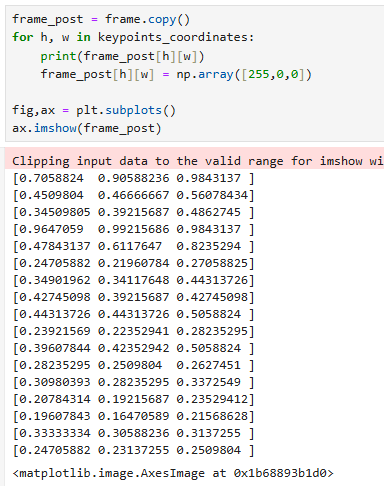
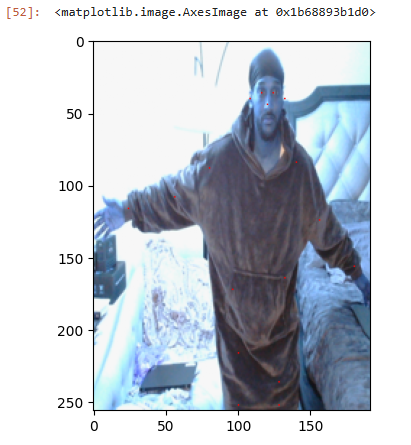

# Not Working

In [ ]:
# cap = cv.VideoCapture(1)

# if not cap.isOpened():
#     print("Some shit just went bad")
#     exit()

# og_height, og_width = expected_shape[2], expected_shape[3]
# output_height, output_width = 64, 48

# scaler_height = og_height/output_height
# scaler_width = og_width/output_width
    
# while True:
#     time.sleep(1)
#     ret, frame = cap.read()
#     if not ret:
#         print("Can't receive frame (stream end?). Exiting...")
#         break

#     # To apply rotation frame needs to be in PIL format
    
#     # frame = Image.fromarray(frame)#Image.fromarray(cv.cvtColor(frame, cv.COLOR_BGR2HSV)) 
#     frame = custom_transform(frame, expected_shape) #transformer(frame) #
#     print(frame.shape)
#     # frame = frame.permute(1,2,0).numpy() #np.transpose(frame,(1,2,0)) #
    
#     ## Will need to permute frame to shape (C, H, W) before inference
#     # This is equivalent to frame.permute(2,0,1) then frame.unsqueeze(0) 
#     # below uses numpy array since we convert above
#     ########################################################################
#     ## INFERENCE
#     ########################################################################
#     inference_frame = np.expand_dims(np.transpose(frame,(2,1,0)), axis=0) 
#     print(inference_frame.shape)
#     outputs = session.run(None, {input_0.name:inference_frame})
#     output_tensor = torch.tensor(outputs).squeeze(0).squeeze(0)
#     print(output_tensor.shape)
#     keypoints_coordinates = []
#     for i in range(output_tensor.shape[0]):
#         # Each i corresponds to a different keypoint
#         heatmap = output_tensor[i]
#         # Grabs max value from heatmap and convert this to height, width
#         max_val = torch.argmax(heatmap)
#         img_height, img_width = torch.unravel_index(max_val, heatmap.shape) #coords = torch.unravel_index(max_val, heatmap.shape)
#         coords = (int(img_height*scaler_height), int(img_width*scaler_width))
#         keypoints_coordinates.append(coords)
#     # # ########################################################################
#     # # ########################################################################
#     # # ########################################################################

#     # # # MAP KEYPOINTS BACK TO ORIGINAL FRAME THEN DISPLAY THAT FRAME
#     print(keypoints_coordinates)
#     frame = (frame*255).astype(np.uint8)
#     frame = frame.copy()
#     print(frame.shape)
#     for (y,x) in keypoints_coordinates:
#         cv.circle(frame, (x,y), radius=3, color=(0,0,255), thickness=-1)
        
#     frame = cv.resize(frame, (640,480), interpolation=cv.INTER_CUBIC)    
#     cv.imshow('frame',frame)
#     if cv.waitKey(1) == ord('q'):
#         break

# cap.release()
# cv.destroyAllWindows()